In [1]:
import sys
import importlib

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import sklearn.preprocessing
from sklearn.preprocessing import normalize

plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.dpi'] = 100
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['font.size'] = 15

# Constants

In [2]:
detector = dict(innernum=16, outernum=15, chunk=6, phinum=8, width=2, film=0.1, interval=0.2, height=7, diameter=175)
image = dict(x=70, y=70, z=96, xnum=140, ynum=140, znum=120, xwidth=0.5, ywidth=0.5, zwidth=0.8)
image = dict(x=70, y=70, z=96, xnum=70, ynum=70, znum=60, xwidth=1., ywidth=1., zwidth=1.6)

In [3]:
x_pixels = np.arange(-image['xnum'] / 2 * image['xwidth'] + image['xwidth'] / 2, image['xnum'] / 2 * image['xwidth'] + image['xwidth'] / 2, image['xwidth'])

y_pixels = np.arange(-image['ynum'] / 2 * image['ywidth'] + image['ywidth'] / 2, image['ynum'] / 2 * image['ywidth'] + image['ywidth'] / 2, image['ywidth'])

z_pixels = np.arange(-image['znum'] / 2 * image['zwidth'] + image['zwidth'] / 2, image['znum'] / 2 * image['zwidth'] + image['zwidth'] / 2, image['zwidth'])

In [4]:
x_det_inner = detector['interval'] / 2 + np.arange((detector['width'] + detector['film']) / 2, detector['innernum'] * (detector['width'] + detector['film']), (detector['width'] + detector['film']))

x_det_inner = np.hstack([-1 * x_det_inner[::-1], x_det_inner])

x_det_outer = (detector['width'] + detector['film'] + detector['interval']) / 2 + np.arange((detector['width'] + detector['film']) / 2, detector['outernum'] * (detector['width'] + detector['film']), (detector['width'] + detector['film']))

x_det_outer = np.hstack([-1 * x_det_outer[::-1], x_det_outer])

In [5]:
y_det_inner = detector['diameter'] / 2

y_det_outer = detector['diameter'] / 2 + detector['height']

In [6]:
z_det_inner = np.arange(-detector['innernum'] / 2 * (detector['width'] + detector['film']) + (detector['width'] + detector['film']) / 2, 
                        detector['innernum'] / 2 * (detector['width'] + detector['film']) + (detector['width'] + detector['film']) / 2, (detector['width'] + detector['film']))

z_det_outer = np.linspace(0, (detector['width'] + detector['film']) * (detector['outernum'] - 1), detector['outernum']) - (detector['width'] + detector['film']) * (detector['outernum'] - 1) / 2

z_displace = detector['innernum'] * detector['width'] + (detector['innernum'] + 1) * detector['film'] + detector['interval']

z_det_inner = np.hstack([z_det_inner + i * z_displace for i in [-1, 0, 1]])

z_det_outer = np.hstack([z_det_outer + i * z_displace for i in [-1, 0, 1]])

In [7]:
R = np.vstack([np.array([[[np.cos(theta), np.sin(theta), 0], [-np.sin(theta), np.cos(theta), 0], [0, 0, 1]]]) for theta in np.arange(8) * np.pi / 4])

In [8]:
X_det_inner, Y_det_inner, Z_det_inner = np.meshgrid(x_det_inner, y_det_inner, z_det_inner)

X_det_outer, Y_det_outer, Z_det_outer = np.meshgrid(x_det_outer, y_det_outer, z_det_outer)

X_pixels, Y_pixels, Z_pixels = np.meshgrid(x_pixels, y_pixels, z_pixels)

xyz_pixels = np.vstack([X_pixels.flatten(), Y_pixels.flatten(), Z_pixels.flatten()]).T

# Transformation matrix

In [9]:
def trans_matrix(method='delta'):
    if method == 'delta':
        matrix = np.zeros((detector['outernum'] ** 2 * detector['chunk'] * detector['phinum'], image['xnum'] * image['ynum'] * image['znum']))#.astype(np.float32)
        for i in tqdm(range(8)):
            xyz_det = np.vstack([X_det_inner.flatten(), Y_det_inner.flatten(), Z_det_inner.flatten()]).T @ R[i]
            nhat = normalize(xyz_det)
            delta = xyz_det[:, None, :] - xyz_pixels
            mhat = delta / np.sqrt((delta ** 2).sum(axis=-1))[:, :, None]
            m = (nhat[:, None, :] * mhat).sum(axis=-1)
            # m = np.zeros((detector['outernum'] ** 2 * detector['chunk'], image['xnum'] * image['ynum'] * image['znum']))
            matrix[detector['outernum'] ** 2 * detector['chunk'] * i:detector['outernum'] ** 2 * detector['chunk'] * (i+1)] = m
    return matrix

In [10]:
b = np.fromfile('LORData_2PointSource', dtype=np.float32)
# b = np.fromfile('LORData_HotRod39M', dtype=np.float32)

In [11]:
a = b.reshape((b.shape[0] // 7, 7))

In [12]:
a.shape

(12695763, 7)

/tmp/ipykernel_24821/4010696421.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


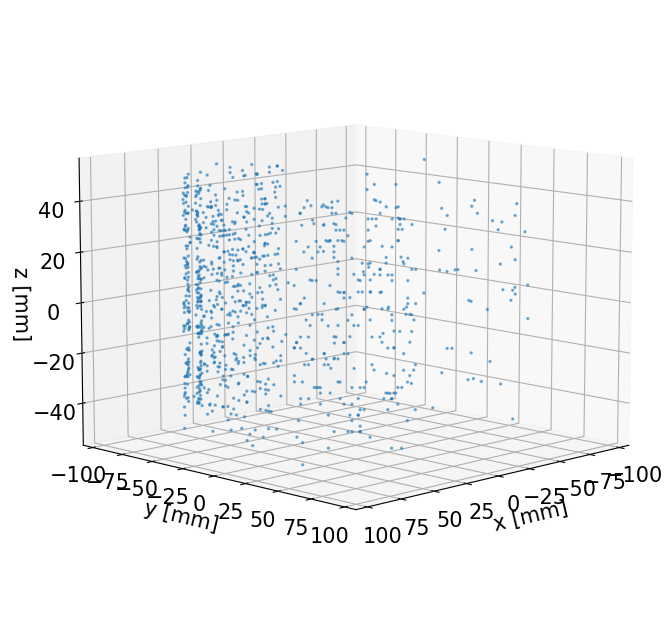

In [13]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')
ax.view_init(elev=10., azim=45.)
ax.scatter(a[:1000, 0], a[:1000, 1], a[:1000, 2], s=2.0, alpha=0.5)
# ax.scatter(a[:1000, 3], a[:1000, 4], a[:1000, 5], s=2.0, alpha=0.5)
# ax.plot([a[0, 0], a[0, 3]], [a[0, 1], a[0, 4]], [a[0, 2], a[0, 5]])
# for i in range(100):
#     ax.plot([a[i, 0], a[i, 3]], [a[i, 1], a[i, 4]], [a[i, 2], a[i, 5]])
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_zlabel('z [mm]')
# fig.savefig('.png'.format(i))

plt.show()